In [204]:
from typing import List, Tuple
import torch
import matplotlib.pyplot as plt

In [280]:
import importlib
import main
importlib.reload(main)

<module 'main' from '/Users/ytakano/projects/dass2023/adv/main.py'>

In [291]:
%%time
x_true, x_free, x_filter, x_smoother = main.run()

CPU times: user 655 ms, sys: 188 ms, total: 843 ms
Wall time: 641 ms


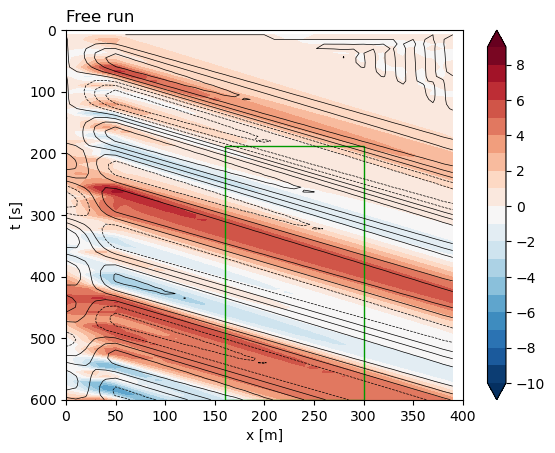

In [292]:
main.plot_xt(
    x_free - x_true, 
    torch.arange(-10, 10, 1), 
    x_free, 
    torch.arange(-20, 20, 5),
    "Free run",
)

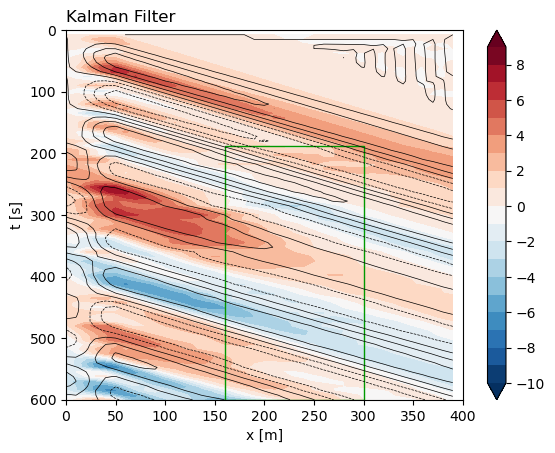

In [293]:
main.plot_xt(
    x_filter - x_true, 
    torch.arange(-10, 10, 1),
    x_filter,
    torch.arange(-20, 20, 5),
    "Kalman Filter"
)

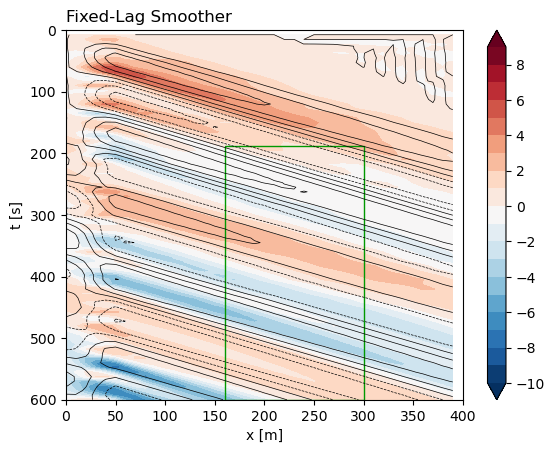

In [294]:
main.plot_xt(
    x_smoother - x_true, 
    torch.arange(-10, 10, 1),
    x_smoother,
    torch.arange(-20, 20, 5),
    "Fixed-Lag Smoother",
)